# 01a_ Introduction to atmospheric transparency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'


In [2]:
from scipy import interpolate

## Imports

- import the atmospheric transparency emulator (instead of using libradtran code).

In [3]:
from importlib.metadata import version
the_ver = version('atmosphtransmemullsst')
print(f"Version of atmosphtransmemullsst : {the_ver}")

Version of atmosphtransmemullsst : 0.0.1


In [4]:
import atmosphtransmemullsst
from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

emul = SimpleAtmEmulator(os.path.join(atmosphtransmemullsst.__path__[0],'../data/simplegrid'))

SimpleAtmEmulator:path=/Users/dagoret/MacOSX/GitHub/LSST/atmosphtransmemullsst/atmosphtransmemullsst/../data/simplegrid


In [5]:
WL = emul.GetWL()

In [6]:
import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [7]:
path_rubin_sim_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline")
atm_std_filename = "atmos_std.dat"

## Configuration

In [8]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

In [9]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

## Initialisation

In [10]:
FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

### Standard filters

We load the standard filters 'effective'for Rubin LSST from `rubin_sim` package. Note those filters includes not only the instrumental filters but also atmosphere transmission.

The atmosphere transmission in those effective filters is called the standard atmosphere. The standard atmosphere is defined as the most representative the atmospheric transmission at the reference airmass $am$ being the most probable airmass calculated form the observation cadence..

By convention the reference airmass $am = 1.2$.

We are going to compute the different transmission filters.
Those will be saved in the following pandas dataframe.

In [11]:
df_std=pd.DataFrame()  # dataframe to hold all transmissions
df_std["wl"] = WL      # wavelength array saved in the dataframe

### Effective transmission

Text(0.5, 1.0, 'Instrument + atmosphere transmission')

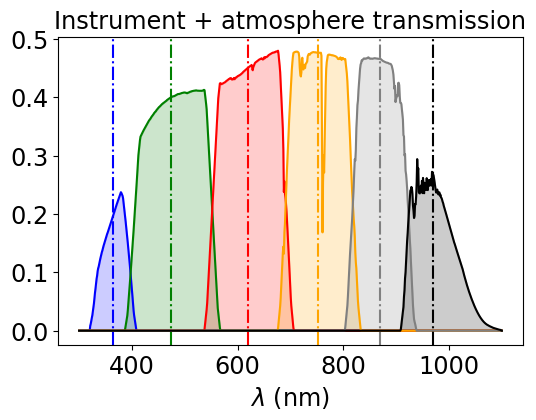

In [12]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
    # filter throughput including atm
    throughput_x_atm = ff(WL)
    # filter throughput without atm
    #throughput2=throughput1/atm_std
    
    tag1="tot_"+filter_tagnames[index] # tagname meaning the total transmission
    
    df_std[tag1] = throughput_x_atm # save the throughput for later use
    
    axs.plot(WL,throughput_x_atm,color=filter_color[index]) 
    axs.fill_between(WL,throughput_x_atm,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument + atmosphere transmission")

We can calculate the instrumental filter by dividing the
effective filter by the standard atmospheric atmosphere transmission

### Standard atmosphere

In [13]:
fullfilename=os.path.join(path_rubin_sim_throughput,atm_std_filename)
arr= np.loadtxt(fullfilename)
    
# interpolate  filter transmission
ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
# filter throughput including atm
transm_atm_std =atm = ff(WL)

Text(0.5, 1.0, 'Standard atmosphere transmission')

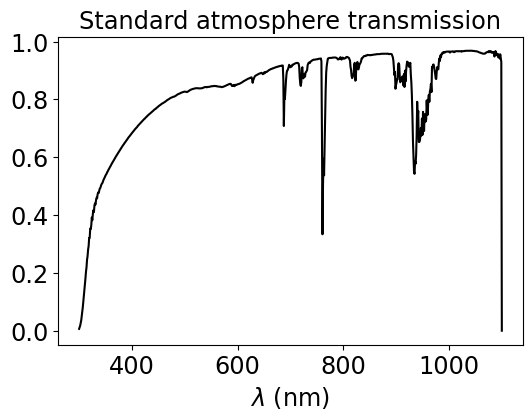

In [14]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(WL,transm_atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

Save the standard atmosphere in the pandas dataframe for later use

In [15]:
df_std["atm"] = transm_atm_std

### Instrumental throughput

By dividing the effective filter transmission by the standard atmospheric transmission, one get the instrumental transmission. It consists in the product of the following transmission or throughput :
- physical filters transmission $(u,g,r,i,z,y)$,
- 3 mirrors relfexion coefficient,
- optics transmission,
- CCD quantum efficiency.


Text(0.5, 1.0, 'Instrument transmission')

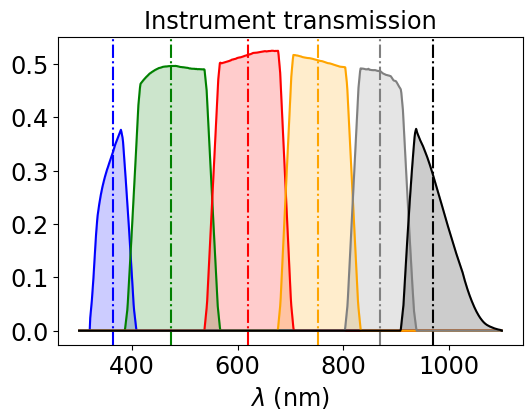

In [16]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    
    
    # filter throughput including atm extracted from pandas dataframe
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = df_std[tag1].values
    # filter throughput without atm
    #throughput2=throughput1/atm_std
    throughput = throughput_x_atm/transm_atm_std 
    tag2 = "inst_"+filter_tagnames[index] # tagname meaning the instrumental transmission
    
    df_std[tag2] = throughput# save the throughput for later use in dataframe
   
    axs.plot(WL,throughput,color=filter_color[index]) 
    axs.fill_between(WL,throughput,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

Note at this point we have saved the transmissions in the folowing dataframe

In [17]:
df_std.head()

,wl,tot_u,tot_g,tot_r,tot_i,tot_z,tot_y,atm,inst_u,inst_g,inst_r,inst_i,inst_z,inst_y
0,300.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.006410,0.0,0.0,0.0,0.0,0.0,0.0
1,301.001252,0.0,0.0,0.0,0.0,0.0,0.0,0.011915,0.0,0.0,0.0,0.0,0.0,0.0
2,302.002503,0.0,0.0,0.0,0.0,0.0,0.0,0.017428,0.0,0.0,0.0,0.0,0.0,0.0
3,303.003755,0.0,0.0,0.0,0.0,0.0,0.0,0.026622,0.0,0.0,0.0,0.0,0.0,0.0
4,304.005006,0.0,0.0,0.0,0.0,0.0,0.0,0.035820,0.0,0.0,0.0,0.0,0.0,0.0


# Question 1 : Estimate the parameters of the standard atmosphere in `rubin_sim`

## Example of calling the atmospheric emulator

In [18]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
taus= [0.04]# Vertical Aerosol depth (VAOD) 
betas = [-1]# Aerosol Angstrom exponent

In [19]:
transm_atm_emul = emul.GetAllTransparencies(WL,am0,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)

## Compare the emulator and the official standard transmission

Text(0.5, 0, '$\\lambda$ (nm)')

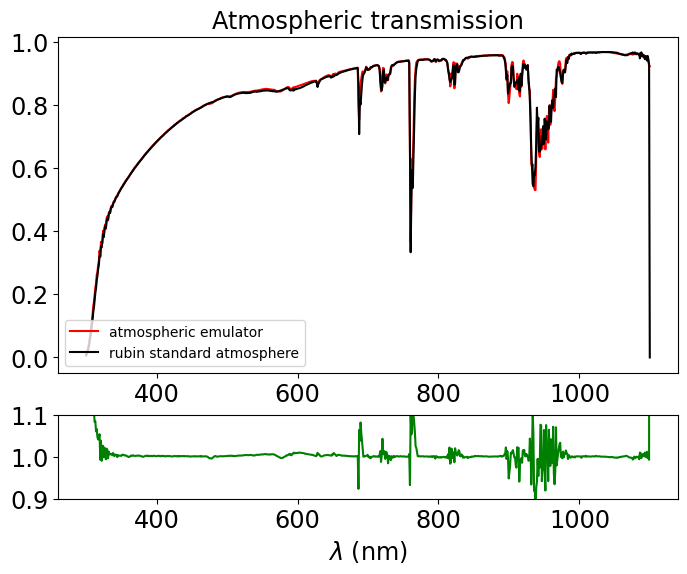

In [20]:
fig = plt.figure(figsize=(8,6))

gs = GridSpec(2, 1,  height_ratios=[4, 1], figure=fig)
axs1 = fig.add_subplot(gs[0,0])

axs1.plot(WL,transm_atm_emul,'r-',label = 'atmospheric emulator ')
axs1.plot(WL,transm_atm_std,'k-', label = "rubin standard atmosphere")
axs1.legend(loc="lower left")
axs1.set_title("Atmospheric transmission")
main_ax =axs1

axs2 = fig.add_subplot(gs[1,0],sharex=main_ax)
axs2.plot(WL,transm_atm_emul/transm_atm_std,'g-',label = 'emulator/rubin-std')
axs2.set_ylim(0.9,1.1)
axs2.set_xlabel("$\\lambda$ (nm)")

### Check the emulator

Text(0.5, 1.0, 'Instrument transmission')

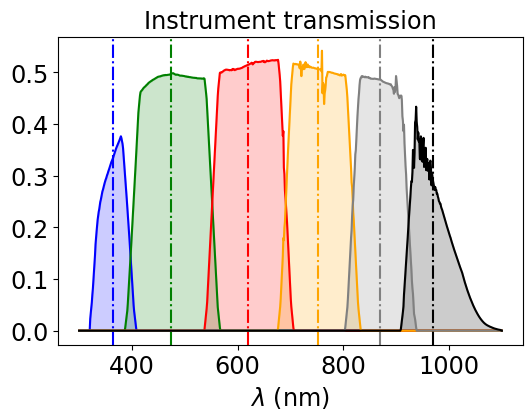

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = df_std[tag1].values
    
    # filter throughput without atm
    throughput = throughput_x_atm/transm_atm_emul 
     
    tag2 ="inst_"+filter_tagnames[index]
      
    axs.plot(WL,throughput,color=filter_color[index]) 
    axs.fill_between(WL,throughput,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

The atmospheric emulator is not that similar to the rubin standard atmosphere.
There seems to be a slight difference in Oxygen lines and H2O bands.
This may be due to different wavelength resolution of the atmospheric model.
This can be checked and corrected.

Because we want to handle atmospheric transmissions with the emulator, whe overwrite the standard transmission in the dataframe.

In [22]:
# loop on filter
for index,filename in enumerate(filter_filenames):
    
    
    tag2 ="inst_"+filter_tagnames[index]
    throughput = df_std[tag2].values
    
    df_std["atm"] = transm_atm_emul
    
    tag1="tot_"+filter_tagnames[index]
    throughput_x_atm = throughput * transm_atm_emul
    
    df_std[tag1] = throughput_x_atm
        

## Impact of atmospheric transmission variation on magnitude accuracy

### Choose an object , thus its SED

`rubin_sim`provide a small set of SEDs for different types of objects.
This small library of SEDs should be installed in 
     ~/rubin_sim_data/photometry_sample

If you don't have it, it is possible to download it from this link:

- https://github.com/rhiannonlynne/photometry_sample

In [23]:
!ls ~/rubin_sim_data/photometry_sample

LICENSE         galaxies        photoZ_outliers quasar          stars
README.md       mag_info        plots           sn              white_dwarf


In [24]:
!ls ~/rubin_sim_data/photometry_sample/stars

km10_4500.fits_g45 km10_6000.fits_g45 km10_7250.fits_g45
km10_5250.fits_g45 km10_6500.fits_g45 m3.0Full.dat


Below we read the whole library to read all the available object type and object

In [25]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [26]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

In [27]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [28]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies
quasar,quasar
km10_5250.fits_g45,stars
km10_4500.fits_g45,stars
km10_6000.fits_g45,stars
km10_7250.fits_g45,stars
km10_6500.fits_g45,stars


In [29]:
sed_name = 'km10_5250.fits_g45'

In [30]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
#z=1.5
#seds['quasar'].redshiftSED(z)

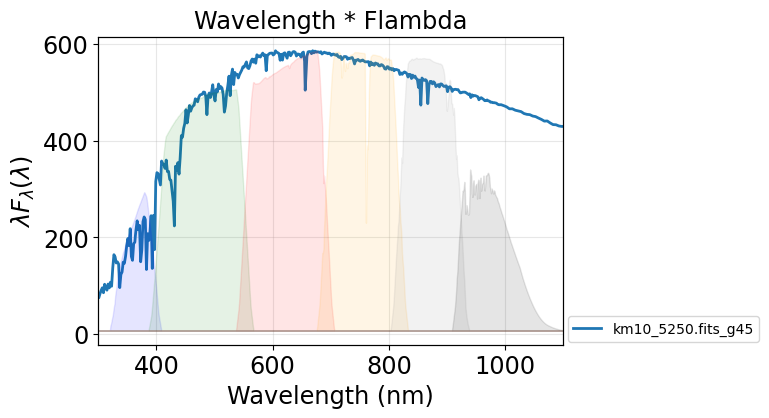

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(seds[sed_name].wavelen, seds[sed_name].flambda * seds[sed_name].wavelen,label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("Wavelength * Flambda")
ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

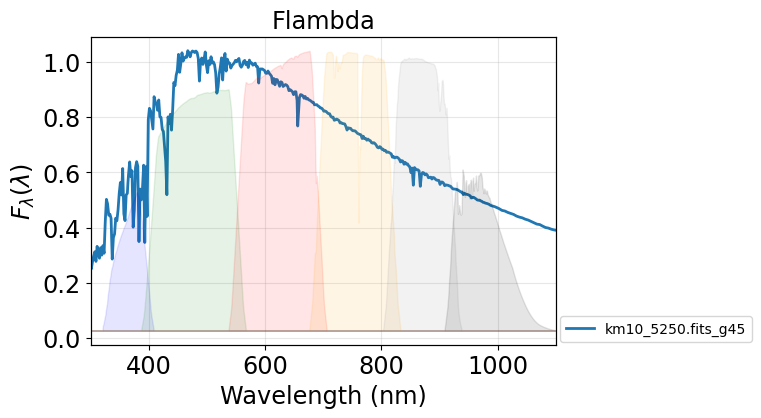

In [32]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(seds[sed_name].wavelen, seds[sed_name].flambda,label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("Flambda")
ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

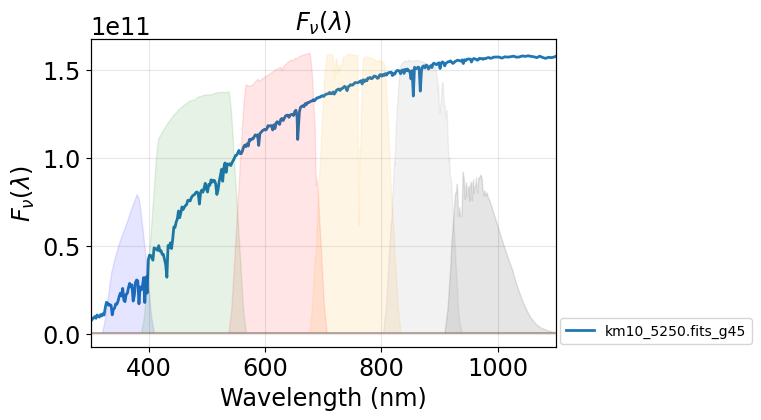

In [33]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(6,4))

wavel,fnu = seds[sed_name].getSED_fnu()
ax.plot(wavel, fnu,label=sed_name,lw=2)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])